# Outlier Detection using character 2-, 3- and 4-grams

## Rationale

In this notebook we describe an experiment that was conducted for the pre-revision paper, but which we have since reanalyzed and decided to be potentially problematic. This negative (or perhaps 'not positive') result is presented for two reasons. In the first place, as a question of methodology, it might be useful to other practitioners who might be considering this kind of approach, and secondly, by presenting the problematic study it might be possible to improve or re-implement it as future work.

## Method

The design is as follows: we take our corpus of classical Latin poetry, preprocessed and broken into chunks as discussed in the UMAP notebook. We use the complete corpus to train a TF-IDF vectorizer, which should give us an 'overall' feeling for n-gram term frequencies across the corpus. We then reduce the dimensionality to 180 (based on the 'alpha' stat, discussed below) from ~34k via Truncated Singular Value Decomposition (SVD). Finally, we projected a large sample of random chunks from Silius into this space, and calculated a bootstrap p-value for the distance of the Additamentum from that centroid.

## Discussion

Analysing distance from a centroid is generally troublesome in high dimensional space. Since there are so many dimensions in which a vector can diverge, what tends to happen is that no points actually lie "close" to the centroid, instead they are distributed near the surface of some hypersphere (sort of like an eggshell). Another problem is that the hyperspheres are not always spheres, they might end up being vague spheroids (eggs, footballs, hamburgers etc). This makes 'pure' distance measurements a little misleading because the clusters are wider along some axes than along others. Mostly we deal with this by using simulation instead of by assuming a distribution (we empirically measure how many random points are further from the centroid rather than making calculations assuming a 'sphere').

In this case, it appears that the TF-IDF feature space is not "stable" under LSA. This can be seen by considering three different corpora which are all _almost_ the same, but produce contradictory results.

## What This Notebook Shows

The general conclusion remains unchanged. The lexico-grammatical style of the Additamentum is closer to the Aeneid and Vergilian style than is typical Silian verse, although it is detectably an outlier from both the _Punica_ and the _Aeneid_. There is some doubt as to whether the specific method that was used to produce a $P$-value is reliable, and so, out of an abundance of caution, we have not made a statistical claim. It does not appear that centroid-based measures are stable enough. The dimensionality of the original TF-IDF space is probably too high.


In [1]:
from bs4 import BeautifulSoup
from mqdq import ngrams
from mqdq import rhyme
from mqdq import hexameter_corpus
from mqdq import utils
from mqdq import line_analyzer as la

import numpy as np
import scipy as sp
import pandas as pd
import math
import string
import pickle
from collections import Counter

from sklearn.utils.extmath import density
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import pairwise_distances
from sklearn.svm import OneClassSVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier

# The Corpora

There are three corpora which are used to build the TF-IDF space. 
Each 'document' is one 81-line chunk of poetry. The 'terms' are 2, 3 and 4-grams. 
The corpus is always preprocessed.

## Phonetic Transformation

All texts are phonetically transformed, which rationalises consonants and 
vowels, differentiates consonantal u/v and i/j, applies elision and prodelision.

## Named Entity Removal

To avoid overfitting, proper nouns are replaced with one token '8' which does not otherwise appear. This allows the models to train on eg the number and line-position of proper nouns without overfitting on telltale names. This is particularly important for this project because the names 'Dido', 'Anna', Aeneas etc would otherwise artificially attract the _Additamentum_ towards the Aeneid.

There are three test corpora, which are only used to establish the TF-IDF space (the terms themselves, ie the column space, and the inverse document frequencies)

## Corpora

- `corpus_A` has the Additamentum broken out into a single chunk. The chunk that 'surrounds' the Addit. is made up of some lines before and then some lines immediately following, so that all chunks are still 81 lines.
- `corpus_B` segments the _Punica_ normally, so the Addit. is broken over two chunks.
- `corpus_C` has the Addit. removed from the Punica (and thus the corpus) entirely.

In general, the correct corpus to use seems to be A. If we remove the Addit. before we construct our TF-IDF weights (`corpus_C`) then we would expect new terms in the Addit. to make it seem more unusual. If we split the Addit over two chunks (`corpus_B`) then the document frequency for n-grams native to the Addit. would be doubled, which would again distort the picture. However the change in the overall corpus is so small that _in theory_ it should make very little difference which of the three corpora we choose.

In [2]:
corpus_A = ngrams.geezit_corpus(chunksz=81, drop_propers=True, drop_addit=True)
corpus_B = ngrams.geezit_corpus(chunksz=81, drop_propers=True, drop_addit=False)
corpus_C = corpus_A.query('Author != "Unknown"')

Here we can see how the differences between `corpus_A` and `corpus_B` line up - since exactly 81 lines
are removed, the differences sync up again by the chunk starting at 
8.258

In [3]:
corpus_A.loc[333:336]

,Chunk,Author,Work,Bookref
333,ad magikas etiam fallaks at_kwimproba gentis\n...,Silius,Punica,8:97
334,i_dut turbarum sator at_kwakkendere sollers\ni...,Silius,Punica,8:258
335,tantum non striktis mukronibus ulla retardet\n...,Silius,Punica,8:339
336,ibant et laeti pars 8 woke kanebant\nauktorem ...,Silius,Punica,8:420


In [4]:
corpus_B.loc[333:336]

,Chunk,Author,Work,Bookref
333,ad magikas etiam fallaks at_kwimproba gentis\n...,Silius,Punica,8:97
334,praeterea ne falsa putes haek fingere 8\nhaud ...,Silius,Punica,8:178
335,i_dut turbarum sator at_kwakkendere sollers\ni...,Silius,Punica,8:259
336,tantum non striktis mukronibus ulla retardet\n...,Silius,Punica,8:340


# Sampled Distributions

For the calculation of centroids etc it is better to have a large sampled distribution, so we take $180^2$ contiguous chunks from the Punica (all lines, so parts of the Addit will appear in some sample chunks).

In [5]:
# The full Punica, with named entities removed. This is what will be used to create
# the sample distribution. We DO include the Additamentum here because that gives us
# a more conservative measure (the result is much stronger when the Additamentum is 
# not included in the comparison data, as one might expect).

with open('SIL-puni.xml') as fh:
    soup = BeautifulSoup(fh,"xml")
ll = utils.clean(soup('line'))
ll_np = ngrams._remove_propers(ll)

# And the same for the Aeneid

with open('VERG-aene.xml') as fh:
    soup = BeautifulSoup(fh,"xml")
aen_ll = utils.clean(soup('line'))
aen_ll_np = ngrams._remove_propers(aen_ll)

In [6]:
# Comparison - text with and without named entity removal
# As can be seen, there are some 'false positives', eg decus
# and gloria are treated as proper nouns because they are
# sometimes anthropomorphised.

ll_p = ngrams._just_stringify(ll, type='phon')
ll_p[:5]

['ordior arma kwibus kaelo se gloria tollit\n',
 'aeneadum patiturkwe feroks oenotria jura\n',
 'kartago da musa dekus memorare laborum\n',
 'anti_kwesperiae kwantos_kwad bella krearit\n',
 'et kwot roma wiros sakri kum perfida pakti\n']

In [7]:
ll_np[:5]

['ordior arma kwibus kaelo se 8 tollit\n',
 '8 patiturkwe feroks 8 jura\n',
 '8 da 8 8 memorare laborum\n',
 'anti_kwesperiae kwantos_kwad bella krearit\n',
 'et kwot 8 wiros sakri kum perfida pakti\n']

In [8]:
# Isolate the lines of the Additamentum, which we will need for various things

addit_lines = ll_np[5230:5311]
ad_chunk = ''.join(addit_lines)
puni_na = ll_np[:5230] + ll_np[5311:]

In [9]:
def sample_chunks(ll, n, chunksz, rng):
    '''
    Take a contiguous sample of n sets, each with length chunksz from the set of lines ll.
    '''
    
    sample = []
    for x in range(n):
        chunk_head = rng.randint(0,len(ll)-chunksz)
        sample.append(''.join(ll[chunk_head:chunk_head+chunksz]))
    return sample

In [10]:
# Sampled distribution, used to calculate centroid etc. Given that we will reduce to 180
# dimensions (discussed next) we take 180^2 samples. This is not always important, but
# in some cases it is. See https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html

DIST_ADDIT_NOPROPS = sample_chunks(ll_np, 180*180, 81, np.random.RandomState(seed=1234))
DIST_PUNI_NA_10K = sample_chunks(puni_na, 10_000, 81, np.random.RandomState(seed=1234))
DIST_AEN = sample_chunks(aen_ll_np, 180*180, 81, np.random.RandomState(seed=1234))

# Why 180 dimensions for the LSA?

Here we will examine the spectrum of the data. We have 793 rows and around 34k columns once we do the TF-IDF transformation, which is massively overspecified. Standard approach is to reduce that feature space, and the typical 'Latent Semantic Analysis' approach does that dimension reduction using Truncated Singular Value Decomposition. Essentially we get the eigenvectors from the data matrix in descending order of eigenvalue and use the first _n_ of them, but how many is reasonable? The scikit documentation says 'For LSA, a value of 100 is recommended', but a more scientific approach is to graph the 'alpha' stat $\alpha = \frac{\sigma_1^2}{\sum_i{\sigma_i^2}}$ for each singular value $\sigma_n$. Intuitively, this $\alpha$ describes 'the eigenvectors where most of the variation happens' for some definition of most, and with the competing constraint that we would like to reduce the dimension as much as we can.

In [11]:
p = make_pipeline(
    TfidfVectorizer(
        use_idf=True,
        sublinear_tf=True,
        norm='l2', 
        analyzer='char',
        ngram_range=(2,4),
    ),
    TruncatedSVD(1000),
)
    
p.fit(corpus_A.Chunk)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(2, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('truncatedsvd',
                 TruncatedSVD(algorithm='randomized', n_components=1000,
                              n_iter=5, random_state=Non

In [12]:
# What does the spectrum look like (roughly)?

param_dir = p.steps[1][1]
svs = param_dir.singular_values_
print("%d singular values." % len(svs))
print("Sum is %.2f. First Eigenvalue is %.2f." % (sum(svs), svs[0]))

793 singular values.
Sum is 652.57. First Eigenvalue is 16.12.


In [13]:
# Calculate alpha for each n in 'the first n singular values'

alpha = []
for i,x in enumerate(svs):
    # The svs in scikit are already squared.
    alpha.append(svs[0]/svs[:i+1].sum())
    
evs = p.steps[1][1].explained_variance_ratio_
ev = []
for i,x in enumerate(evs):
    ev.append(evs[:i+1].sum())

In [14]:
# I don't do much matplot, but this is just a quick exploration

%matplotlib inline
import matplotlib.pyplot as plt

# Discussion

Any value from 100 to 200 is probably reasonable based on the 'elbow' of the alpha curve. Since the explained variance climbs extremely slowly, we have preferred higher values. In a separate experiment we found that p-values for the one-class outlier experiment tended to stabilize at about 180 dimensions, so that is the number we have chosen for classification tests, but the number really isn't that important overall.

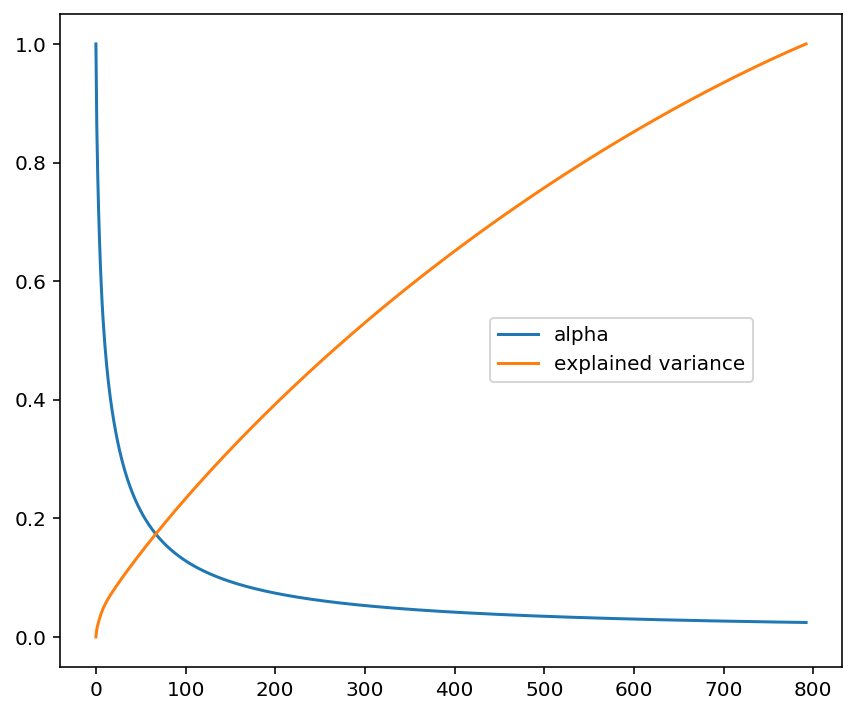

In [15]:
plt.figure(figsize=(7,6),dpi=144)
plt.plot(np.arange(0,len(svs)),alpha,label='alpha')
plt.plot(np.arange(0, len(evs)),ev,label="explained variance")
plt.legend(bbox_to_anchor=[0.9,0.55])
plt.show()

# Our Initial Experiment

Based on the spectrum analysis, we defined the experiment as follows:
- Create a TF-IDF feature space based on the full corpus (since there is no reason to suppose the _Additamentum_ is by Silius)
- Create a sampled distribution of continguous 81-line chunks from Silius
- Transform the sampled distribution with TF-IDF, and perform SVD at 180 dimensions
- Project the transformed _Additamentum_ into the same space
- Calculate an empirical p-value by determining how many of the sampled chunks are further from the geometric median of the Silian points

# Utility Functions

In [16]:
# The geometric median is the L1 equivalent of the Euclidean distance. Just as the
# median is more robust in the presence of outliers, so the geometric median is
# more robust than the L2 centroid.

# Unfortunately, it is much more annoying to calculate. The idea is to find a point
# that minimizes the straight line distance to every point we're considering. The 
# algorithm, boiled down, picks a point and then moves it around until the distance
# stops getting smaller. 

from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    """
    https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points
    [QUOTING THE POST AUTHOR]
    I implemented Yehuda Vardi and Cun-Hui Zhang's algorithm for the geometric median,
    described in their paper "The multivariate L1-median and associated data depth".
    Everything is vectorized in numpy, so should be very fast. I didn't implement 
    weights - only unweighted points.
    """
    
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [17]:
tfidf = TfidfVectorizer(
    use_idf=True,
    sublinear_tf=True,
    norm='l2', 
    analyzer='char',
    ngram_range=(2,4),
)
lsa = make_pipeline(
    TruncatedSVD(180, n_iter=10, random_state=42),
    #Normalizer(copy=False),
)


# fit the TF-IDF weights etc to this corpus.
corpus_vecs = tfidf.fit_transform(corpus_A.Chunk)
# calculate the eigenvectors based only on the actual corpus
lsa.fit(corpus_vecs)
puni_dist_tfidf = tfidf.transform(DIST_ADDIT_NOPROPS)
dist_vecs_puni = lsa.transform(puni_dist_tfidf)
# to calculate the centroid, take the geometric median in full dimension, then transform
cent_puni = geometric_median(np.asarray(puni_dist_tfidf.todense())).reshape(1,-1)
cent_puni_svd = lsa.transform(cent_puni)

ad_vec = lsa.transform(tfidf.transform([ad_chunk]))
ad_dist_puni = pairwise_distances(cent_puni_svd, ad_vec, metric='l2')[0][0]

puni_dists = [pairwise_distances(cent_puni_svd, x.reshape(1,-1), metric='l2')[0][0] for x in dist_vecs_puni]
print("Percentage of PUNICA points FURTHER from Punica (than Addit): %2.2f" % (len([x for x in puni_dists if x > ad_dist_puni])/len(puni_dists)*100))
print("")

Percentage of PUNICA points FURTHER from Punica (than Addit): 1.05



# Discussion

The result indicated that the _Additamentum_ is an outlier with bootstrap $P < 0.05$. However, on further investigation, we discovered that the LSA space is extremely sensitive to the TF-IDF feature space. While it is clear from the classifier tests that clustering performance is strong, the relative locations of various points (and perhaps their centroids in general) seems to be very unstable.

In the further experiments below we show:
- Depending on the corpus (`A`, `B` or `C`), the geometry of the SVD space changes wildly
- geometric outlier methods (as a single-class problem) might not be reliable in these spaces
- The TF-IDF space itself is stable (the results don't change much between the three corpora)

Unfortunately, the dimensionality of the full TF-IDF space is too high to use geometric methods.

In [18]:
tfidf = TfidfVectorizer(
    use_idf=True,
    sublinear_tf=True,
    norm='l2', 
    analyzer='char',
    ngram_range=(2,4),
)
lsa = make_pipeline(
    TruncatedSVD(180, n_iter=10, random_state=42),
    Normalizer(copy=False),
)

for cp in [corpus_A, corpus_B, corpus_C]:

    # fit the TF-IDF weights etc to this corpus.
    corpus_vecs = tfidf.fit_transform(cp.Chunk)
    # calculate the eigenvectors based only on the actual corpus
    lsa.fit(corpus_vecs)
    puni_dist_tfidf = tfidf.transform(DIST_ADDIT_NOPROPS)
    dist_vecs_puni = lsa.transform(puni_dist_tfidf)
    # to calculate the centroid, take the geometric median in full dimension, then transform
    cent_puni = geometric_median(np.asarray(puni_dist_tfidf.todense())).reshape(1,-1)
    cent_puni_svd = lsa.transform(cent_puni)

    dist_aen_tfidf = tfidf.transform(DIST_AEN)
    dist_vecs_aen = lsa.transform(dist_aen_tfidf)
    cent_aen = geometric_median(np.asarray(dist_aen_tfidf.todense())).reshape(1,-1)
    cent_aen_svd = lsa.transform(cent_aen)

    ad_vec = lsa.transform(tfidf.transform([ad_chunk]))
    ad_dist_puni = pairwise_distances(cent_puni_svd, ad_vec, metric='l2')[0][0]
    ad_dist_aen = pairwise_distances(cent_aen_svd, ad_vec, metric='l2')[0][0]

    print("Addit distance from Puni centroid: %.4f" % ad_dist_puni)
    print("Addit distance from Aeneid centroid: %.4f" % ad_dist_aen)

    print("Distance from Puni centroid to Aeneid centroid: %.4f" % pairwise_distances(cent_aen_svd, cent_puni_svd, metric='l2')[0][0])

    aen_dists = [pairwise_distances(cent_aen_svd, x.reshape(1,-1), metric='l2')[0][0] for x in dist_vecs_puni]
    print("Percentage of PUNICA points CLOSER to Aeneid (than Addit): %2.2f" % (len([x for x in aen_dists if x < ad_dist_aen])/len(aen_dists)*100))

    puni_dists = [pairwise_distances(cent_puni_svd, x.reshape(1,-1), metric='l2')[0][0] for x in dist_vecs_puni]
    print("Percentage of PUNICA points FURTHER from Punica (than Addit): %2.2f" % (len([x for x in puni_dists if x > ad_dist_puni])/len(puni_dists)*100))
    print("")

Addit distance from Puni centroid: 0.6982
Addit distance from Aeneid centroid: 0.7032
Distance from Puni centroid to Aeneid centroid: 0.2958
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 89.12
Percentage of PUNICA points FURTHER from Punica (than Addit): 1.32

Addit distance from Puni centroid: 0.5655
Addit distance from Aeneid centroid: 0.5791
Distance from Puni centroid to Aeneid centroid: 0.2958
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 4.20
Percentage of PUNICA points FURTHER from Punica (than Addit): 63.51

Addit distance from Puni centroid: 0.3146
Addit distance from Aeneid centroid: 0.3239
Distance from Puni centroid to Aeneid centroid: 0.2958
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 0.04
Percentage of PUNICA points FURTHER from Punica (than Addit): 99.95



## Metric outlier methods on SVD projections of high-dimensional data are confusing

Looking at the results above, it seems clear that the geometry of the truncated SVD space is extremely sensitive to the input TF-IDF data, and metric-topological methods (centroid etc) seem fragile. Some other notes:
- In the first two projections, the Addit is further from either centroid that the centroids are from each other. Although this is difficult to interpret, it _might_ support the theory that it is not written by either author, but is derivative of both.
- In the results from `corpus_C` (not including the Addit in the TF-IDF training data), the fact that 99.9% of Punica points are further from the Punica centroid than the Addit is, itself, very strange. Points in high dimension usually lie in a thin 'shell' at quite a distance from the centroid. This is a consequence of the way high-dimensional metrics work (there are many 'directions' in which the data can diverge, so the 'minimum' distance given normal noise is quite far from the centroid). It is much more likely that the Addit is a point that is diverging from a different centroid entirely (which would support the claim of interpolation)
- Further to that point, the distances from the centroid appear (based on a QQ plot, not shown) to be normally distributed about a mean. In that sense, a point being unusually close to the centroid is also an 'outlier' in the statistical sense.

My current hypothesis is that a small change in a couple of eigenvalues means that a completely different eigenbasis is chosen, since the 'best' n vectors (ie with the highest eigenvalues) are the ones chosen for the reduction and that the position of anomalous points therefore varies greatly. In addition, the SVD process suffers from 'sign indeterminancy' in that the 'directions' in the basis can be switched, ie the same model, fit twice, might produce the same basis except with a few directions swapped, which would completely change the position of points with strong components in those directions.

In general, the first experiment still seems to be the 'correct' one, but more broadly I am unsure, at this time, that metric-topological methods are appropriate for SVD projections of very high dimensional data (or at least not for this very high dimensional data) and so I have chosen not to present these results.

## Repeating the experiment at 100 dimensions (per the documentation) - no change

In [19]:
tfidf = TfidfVectorizer(
    use_idf=True,
    sublinear_tf=True,
    norm='l2', 
    analyzer='char',
    ngram_range=(2,4),
)
lsa = make_pipeline(
    TruncatedSVD(100, n_iter=10, random_state=42),
    #Normalizer(copy=False),
)

for cp in [corpus_A, corpus_B, corpus_C]:

    # fit the TF-IDF weights etc to this corpus.
    corpus_vecs = tfidf.fit_transform(cp.Chunk)
    # calculate the eigenvectors based only on the actual corpus
    lsa.fit(corpus_vecs)
    puni_dist_tfidf = tfidf.transform(DIST_ADDIT_NOPROPS)
    dist_vecs_puni = lsa.transform(puni_dist_tfidf)
    # to calculate the centroid, take the geometric median in full dimension, then transform
    cent_puni = geometric_median(np.asarray(puni_dist_tfidf.todense())).reshape(1,-1)
    cent_puni_svd = lsa.transform(cent_puni)

    dist_aen_tfidf = tfidf.transform(DIST_AEN)
    dist_vecs_aen = lsa.transform(dist_aen_tfidf)
    cent_aen = geometric_median(np.asarray(dist_aen_tfidf.todense())).reshape(1,-1)
    cent_aen_svd = lsa.transform(cent_aen)

    ad_vec = lsa.transform(tfidf.transform([ad_chunk]))
    ad_dist_puni = pairwise_distances(cent_puni_svd, ad_vec, metric='l2')[0][0]
    ad_dist_aen = pairwise_distances(cent_aen_svd, ad_vec, metric='l2')[0][0]

    print("Addit distance from Puni centroid: %.4f" % ad_dist_puni)
    print("Addit distance from Aeneid centroid: %.4f" % ad_dist_aen)

    print("Distance from Puni centroid to Aeneid centroid: %.4f" % pairwise_distances(cent_aen_svd, cent_puni_svd, metric='l2')[0][0])

    aen_dists = [pairwise_distances(cent_aen_svd, x.reshape(1,-1), metric='l2')[0][0] for x in dist_vecs_puni]
    print("Percentage of PUNICA points CLOSER to Aeneid (than Addit): %2.2f" % (len([x for x in aen_dists if x < ad_dist_aen])/len(aen_dists)*100))

    puni_dists = [pairwise_distances(cent_puni_svd, x.reshape(1,-1), metric='l2')[0][0] for x in dist_vecs_puni]
    print("Percentage of PUNICA points FURTHER from Punica (than Addit): %2.2f" % (len([x for x in puni_dists if x > ad_dist_puni])/len(puni_dists)*100))
    print("")

Addit distance from Puni centroid: 0.4160
Addit distance from Aeneid centroid: 0.4199
Distance from Puni centroid to Aeneid centroid: 0.1729
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 96.73
Percentage of PUNICA points FURTHER from Punica (than Addit): 0.35

Addit distance from Puni centroid: 0.3166
Addit distance from Aeneid centroid: 0.3258
Distance from Puni centroid to Aeneid centroid: 0.1729
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 15.23
Percentage of PUNICA points FURTHER from Punica (than Addit): 45.44

Addit distance from Puni centroid: 0.1608
Addit distance from Aeneid centroid: 0.1684
Distance from Puni centroid to Aeneid centroid: 0.1730
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 0.10
Percentage of PUNICA points FURTHER from Punica (than Addit): 99.96



## Corpus differences make little difference using un-reduced TF-IDF data

Intuitively, such a small difference between the corpora should have made little difference, and indeed it makes little difference to the results taken in full dimensionality, as verified below. The variability is somehow a result of the SVD process.

This is NOT an argument for using centroid measures (distance-metric based measures in general) on the un-reduced data, since the dimension is vastly overspecified compared to the number of samples.

In [20]:
tfidf = TfidfVectorizer(
    use_idf=True,
    sublinear_tf=True,
    norm='l2', 
    analyzer='char',
    ngram_range=(2,4),
)


for cp in [corpus_A, corpus_B, corpus_C]:

    # fit the TF-IDF weights etc to this corpus.
    corpus_vecs = tfidf.fit_transform(cp.Chunk)
    # calculate the eigenvectors based only on the actual corpus
    puni_dist_tfidf = tfidf.transform(DIST_ADDIT_NOPROPS)
    # to calculate the centroid, take the geometric median in full dimension, then transform
    cent_puni = geometric_median(np.asarray(puni_dist_tfidf.todense())).reshape(1,-1)

    dist_aen_tfidf = tfidf.transform(DIST_AEN)
    cent_aen = geometric_median(np.asarray(dist_aen_tfidf.todense())).reshape(1,-1)

    ad_vec = tfidf.transform([ad_chunk])
    ad_dist_puni = pairwise_distances(cent_puni, ad_vec, metric='l2')[0][0]
    ad_dist_aen = pairwise_distances(cent_aen, ad_vec, metric='l2')[0][0]

    print("Addit distance from Puni centroid: %.4f" % ad_dist_puni)
    print("Addit distance from Aeneid centroid: %.4f" % ad_dist_aen)

    print("Distance from Puni centroid to Aeneid centroid: %.4f" % pairwise_distances(cent_aen, cent_puni, metric='l2')[0][0])

    aen_dists = [pairwise_distances(cent_aen, x.reshape(1,-1), metric='l2')[0][0] for x in puni_dist_tfidf]
    print("Percentage of PUNICA points CLOSER to Aeneid (than Addit): %2.2f" % (len([x for x in aen_dists if x < ad_dist_aen])/len(aen_dists)*100))

    puni_dists = [pairwise_distances(cent_puni, x.reshape(1,-1), metric='l2')[0][0] for x in puni_dist_tfidf]
    print("Percentage of PUNICA points FURTHER from Punica (than Addit): %2.2f" % (len([x for x in puni_dists if x > ad_dist_puni])/len(puni_dists)*100))
    print("")

Addit distance from Puni centroid: 0.8196
Addit distance from Aeneid centroid: 0.8259
Distance from Puni centroid to Aeneid centroid: 0.1763
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 44.59
Percentage of PUNICA points FURTHER from Punica (than Addit): 11.07

Addit distance from Puni centroid: 0.8195
Addit distance from Aeneid centroid: 0.8258
Distance from Puni centroid to Aeneid centroid: 0.1763
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 44.19
Percentage of PUNICA points FURTHER from Punica (than Addit): 11.25

Addit distance from Puni centroid: 0.8197
Addit distance from Aeneid centroid: 0.8260
Distance from Puni centroid to Aeneid centroid: 0.1764
Percentage of PUNICA points CLOSER to Aeneid (than Addit): 45.15
Percentage of PUNICA points FURTHER from Punica (than Addit): 10.94



# Other approaches - OneClassSVM

SVMs with linear kernels scale well to large dimensions, and have been used for outlier detection, with the most common being the One-class SVM. In the experiment below we find the following:
- With the _Additamentum_ included, we trained a `OneClassSVM` on a sampled distribution of 5000 contiguous 81-line chunks from the _Punica_. At the 95% confidence level it was detected as an inlier.
- Without the _Additamentum_ in the training data (training only on securely Silian text) it is detected as an outlier at the same threshold.
- If the _Additamentum_ is spliced into the _Aeneid_ it is detected as an _inlier_, but an outlier if not.

Based on this I suggest that the _Additamentum_ is right at the edge of the threshold in terms of stylistic similarity to _both_ the _Aeneid_ and the _Punica_ but in fact is an outlier from both texts at the 95% confidence level. Again, this is consistent with the work of an interpolator trained on Vergil who is attempting (and doing an excellent job) to imitate Silius.

Again, this result is NOT reported in the paper because I do not consider it to be a 'secure' $P$-value. The statistical hypothesis when setting up a One-class SVM with a given contamination level is...complex. Perhaps I am being too conservative here.

Based on this and many other tests conducted on this data (various other metric tests, work with multiclass classifiers, other outlier detection methods...) I remain confident in the general finding:

### The _Additamentum_ is right at the edge of the detectable stylistic boundary of _both_ the _Aeneid_ and the _Punica_ when considering lexico-grammatical style as reflected by LSA. Nevertheless, it is an outlier from both works.

In [21]:
def howmany(key, corpus):
    _, work = key.split('--')
    return len(corpus[corpus.Work==work])

In [22]:
def oneclass_svm_experiment(corpus_ll, addit_ll, insert_at=None, comp_corpus=corpus_A, n=5000, contamination=0.05):
    '''
    For the given corpus, perform the following experiment using a One Class SVM for outlier
    detection:
      * Create a sampled distribution of n chunks of 81 lines from the work given
      * TF-IDF transform the sample
      * Train a One Class SVM on the transformed sample at full dimensionality
      * Predict FROM THE ORIGINAL CORPUS which chunks are inliers
      * Repeat the steps above, but with the Additamentum spliced into the middle of the lines
    '''
    
    print("Running at %.1f%% contamination, sample n=%d\n" % (contamination*100, n))
    
    tfidf = TfidfVectorizer(
        sublinear_tf=True, 
        use_idf=True,
        norm='l2', 
        analyzer='char',
        ngram_range=(2,4)
    )
    
    if not insert_at:
        insert_at = len(corpus_ll)//2
    if insert_at+81 > len(corpus_ll):
        raise ValueError("Trying to insert past end of text")
        
    # Run 1
    print("Run 1 -- Training on text only")
    dist = sample_chunks(corpus_ll, n, 81, np.random.RandomState(seed=1234))
    dist_tfidf = tfidf.fit_transform(dist)
    # The RBF kernel is generally as good or better but linear kernel is MUCH
    # faster, and the dimensionality is high here. In other tests, linear
    # and rbf SVMs for classification were both so accurate as to be indistinguishable
    ocsvm = OneClassSVM(nu=contamination, kernel="linear",gamma='scale')
    ocsvm.fit(dist_tfidf)
    corpus_preds = ocsvm.predict(tfidf.transform(comp_corpus.Chunk))
    # select the rows from the original corpus at the locations where the
    # prediction vector is '1' (for inlier)
    keys = comp_corpus.loc[corpus_preds==1][['Author','Work']].agg('--'.join, axis=1)
    ctr = Counter(keys)
    preds = '\n'.join(["  %s: %d/%d" % (k,v,howmany(k,comp_corpus)) for (k,v) in  ctr.items()])
    print("Chunks detected as inliers:\n%s\n" % preds)
    
    # Run 2
    
    print("Run 2 -- Splicing Additamentum into training text at line %d" % insert_at)
    spliced = corpus_ll[:insert_at] + addit_ll + corpus_ll[insert_at:]
    dist = sample_chunks(spliced, n, 81, np.random.RandomState(seed=1234))
    dist_tfidf = tfidf.fit_transform(dist)
    ocsvm = OneClassSVM(nu=contamination, kernel="linear",gamma='scale')
    ocsvm.fit(dist_tfidf)
    corpus_preds = ocsvm.predict(tfidf.transform(comp_corpus.Chunk))
    keys = comp_corpus.loc[corpus_preds==1][['Author','Work']].agg('--'.join, axis=1)
    ctr = Counter(keys)
    preds = '\n'.join(["  %s: %d/%d" % (k,v,howmany(k,comp_corpus)) for (k,v) in  ctr.items()])
    print("Chunks detected as inliers:\n%s\n" % preds)

# Experiment Description

For the given corpus, perform the following experiment using a One Class SVM for outlier
detection:
  * Create a sampled distribution of n chunks of 81 lines from the work given
  * TF-IDF transform the sample
  * Train a One Class SVM on the transformed sample at full dimensionality
  * Predict FROM THE ORIGINAL CORPUS which chunks are inliers
  * Repeat the steps above, but with the Additamentum spliced into the middle of the lines
  
So, eg, when we train on the _Punica_, and then use that classifier to examine the entire corpus, it picks 136/150 of the real Punica chunks, and also a few chunks of the Aeneid, Thebaid and Pharsalia (all works to which Silius has known intertextual links). When trained on the _Aeneid_ it likewise picks most of those chunks as well as a few of Silius, Ovid and Statius. The results seem more or less as expected. Remember that the `OneClassSVM` is trained with a contamination value of 5% and so it would be expected to reject 5% of the chunks of genuine Silius (actually it rejects ~10%) or the genuine _Aeneid_ (it rejects very close to 5%). Silius is more varible in lexico-grammatical style than Vergil in the _Aeneid_.

### NOTE: Hacking random results

Choosing exactly where to insert the Addit raises the spectre of "result hacking", which indeed it is. In fact, when inserted in the exact middle of both texts it was detected as an outlier in both cases (when included in the training data and when omitted). Given that I wanted to demonstrate that _sometimes_ it is detected as an inlier, I had to choose values where that happened. Essentially I am hacking the results to force them to display a weakness (if the Addit were always detected as an outlier that would be a stronger result).

In [23]:
oneclass_svm_experiment(puni_na, addit_lines, insert_at=5230)

Running at 5.0% contamination, sample n=5000

Run 1 -- Training on text only
Chunks detected as inliers:
  Vergil--Aeneid: 3/121
  Silius--Punica: 136/150
  Statius--Thebaid: 2/120
  Lucan--Pharsalia: 6/99

Run 2 -- Splicing Additamentum into training text at line 5230
Chunks detected as inliers:
  Vergil--Aeneid: 3/121
  Silius--Punica: 138/150
  Unknown--Punica: 1/150
  Statius--Thebaid: 2/120
  Lucan--Pharsalia: 7/99



In [24]:
oneclass_svm_experiment(aen_ll_np, addit_lines, insert_at=5000)

Running at 5.0% contamination, sample n=5000

Run 1 -- Training on text only
Chunks detected as inliers:
  Vergil--Aeneid: 115/121
  Ovid--Metamorphoses: 2/148
  Silius--Punica: 9/150
  Statius--Thebaid: 4/120

Run 2 -- Splicing Additamentum into training text at line 5000
Chunks detected as inliers:
  Vergil--Aeneid: 115/121
  Ovid--Metamorphoses: 2/148
  Silius--Punica: 11/150
  Unknown--Punica: 1/150
  Statius--Thebaid: 4/120



In [25]:
# Just splicing in the Addit to the Punica isn't enough to ensure it will be detected as
# an inlier, it is sensitive to the location and the random sample. This seems to be
# further evidence that it is right on the stylistic border.

oneclass_svm_experiment(puni_na, addit_lines)

Running at 5.0% contamination, sample n=5000

Run 1 -- Training on text only
Chunks detected as inliers:
  Vergil--Aeneid: 3/121
  Silius--Punica: 136/150
  Statius--Thebaid: 2/120
  Lucan--Pharsalia: 6/99

Run 2 -- Splicing Additamentum into training text at line 6059
Chunks detected as inliers:
  Vergil--Aeneid: 2/121
  Silius--Punica: 139/150
  Statius--Thebaid: 2/120
  Lucan--Pharsalia: 6/99



# Other Approaches - Multiclass Classifier Experiments

This last exploration is in support of the claim that the style is closer to the Aeneid than the Punica, and much more in imitation of Vergil than Silius' general style. It should first be emphasised that in a multi-class classification, the computer is forced to choose between a fixed set of labels, it can't guess 'non of the above' (which is what is being claimed, ie that the Addit is by an unknown interpolator). There is no possibility, obviously, that the style is actually Vergilian, simply that the algorithm thinks it is _more like Vergil than Silius_. 

Classifiers are not really good ways to support (or refute) claims of non-genuineness. The experiments below are offered simply in the spirit of open investigation.

In [26]:
def mean_confidence_interval(data, confidence=0.95):
    '''
    Calculate the 95% confidence interval around the mean for an array of numbers.
    Uses one-sample T-test.
    '''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [27]:
def classifier_test(clf, corp, test_chunk, use_svd=True, do_cv=True, refits=10, fit_dist=True):
    
    p=None
    rng = np.random.RandomState(seed=1234)
    
    if use_svd:
        print("Running SVD at 180 dimensions.")
        p = make_pipeline(
            TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
            TruncatedSVD(180, random_state=rng),
            Normalizer(copy=False),
            clf,
        )
    else:
        print("Running at full dimensionality.")
        p = make_pipeline(
            TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
            clf,
        )
        
    print("Testing Classifier: %s" % clf)
    clf_res = {'Author':[], 'Work':{}}
    if do_cv:
        print("Doing 10 fold CV with 80/20 split, recall weighted")
        s = cross_val_score(p, corp.Chunk, corp.Work, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2), n_jobs=-1, scoring='recall_weighted')
        m,h = mean_confidence_interval(s)
        clf_res['Work']=[m,h]
        print("Accuracy (Work): %.2f%% ± %.3f" % (m*100, h*100))
        s = cross_val_score(p, corp.Chunk, corp.Author, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2), n_jobs=-1, scoring='recall_weighted')
        m,h = mean_confidence_interval(s)
        clf_res['Author']=[m,h]
        print("Accuracy (Author): %.2f%% ± %.3f" % (m*100, h*100))
        
    print("Refitting %d times" % refits)
    pred_auths, pred_works = [], []
    for _ in range(refits):
        p.fit(corp.Chunk, corp.Author)
        pred_auths.append(p.predict([test_chunk])[0])
        p.fit(corp.Chunk, corp.Work)
        pred_works.append(p.predict([test_chunk])[0])
    print("Predicting for the test chunk. Author: %s. Work: %s." % (Counter(pred_auths), Counter(pred_works)))
    
    # How many random chunks of securely attributed Punica are predicted as something else?
    dist_preds = Counter([])
    if fit_dist:
        p.fit(corp.Chunk, corp.Work)
        dist_works = Counter(p.predict(DIST_PUNI_NA_10K))
        p.fit(corp.Chunk, corp.Author)
        dist_auths = Counter(p.predict(DIST_PUNI_NA_10K))
        print("Predicting for 10,000 random Punica Chunks. Author: %s. Work: %s" % (dist_auths, dist_works))
    
    #return (clf_res, pred_auths, pred_works, dist_preds)

# Multi-class Classification with K-Nearest Neighbours

Since we have decided that distance-metric measures are unstable in the SVD space but the _local_ topology seems OK (it's still some kind of Riemannian manifold)  I experiment here with K-Nearest Neighbours, as well as some other classifiers that are generally considered suitable for high dimension problems.

We work here with two corpora. Since this is a classification test, we use `corpus_C` as a base, since we can't have the chunk of interest (the Addit) in the training data. I also test with a subset of `corpus_C` containing ONLY the _Aeneid_ and the _Punica_.

In [28]:
# One heuristic for KNN is to use sqrt(n) neighbours, but the best approach always depepnds on the data.

aenpu = corpus_C.query('Work=="Aeneid" or Work=="Punica"')
math.sqrt(len(aenpu))

16.431676725154983

## K-Nearest Neighbours predicts the Additamentum to be the _Aeneid_ with low K

At higher values of K the value changes to predict the _Punica_. Again this seems consistent with the idea that the Additamentum is at the stylistic boundary between the works. However when the results for 10,000 random contiguous chunks of the (securely attributed) Punica are predicted at $K=5$, none of them are predicted as the Aeneid. 

### This again supports the conclusion that whatever the prediction result (and clearly the predictions vary by classifier and by parameter selection), the _Additamentum_ chunk is much closer to the style of the _Aeneid_ than typical Silian style.


In [29]:
classifier_test(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean'), aenpu, ad_chunk, do_cv=True, use_svd=False, refits=1, fit_dist=True)

Running at full dimensionality.
Testing Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
Doing 10 fold CV with 80/20 split, recall weighted
Accuracy (Work): 98.89% ± 0.926
Accuracy (Author): 98.15% ± 1.396
Refitting 1 times
Predicting for the test chunk. Author: Counter({'Vergil': 1}). Work: Counter({'Aeneid': 1}).
Predicting for 10,000 random Punica Chunks. Author: Counter({'Silius': 10000}). Work: Counter({'Punica': 10000})


In [30]:
classifier_test(KNeighborsClassifier(n_neighbors=17), aenpu, ad_chunk, do_cv=True, use_svd=False, refits=1, fit_dist=False)

Running at full dimensionality.
Testing Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')
Doing 10 fold CV with 80/20 split, recall weighted
Accuracy (Work): 100.00% ± 0.000
Accuracy (Author): 99.63% ± 0.559
Refitting 1 times
Predicting for the test chunk. Author: Counter({'Silius': 1}). Work: Counter({'Punica': 1}).


In [31]:
classifier_test(KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean'), corpus_C, ad_chunk, do_cv=True, use_svd=False, refits=1, fit_dist=True)

Running at full dimensionality.
Testing Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
Doing 10 fold CV with 80/20 split, recall weighted
Accuracy (Work): 96.23% ± 1.162
Accuracy (Author): 97.11% ± 0.905
Refitting 1 times
Predicting for the test chunk. Author: Counter({'Vergil': 1}). Work: Counter({'Aeneid': 1}).
Predicting for 10,000 random Punica Chunks. Author: Counter({'Silius': 9954, 'Lucan': 46}). Work: Counter({'Punica': 9954, 'Pharsalia': 46})


In [32]:
classifier_test(KNeighborsClassifier(n_neighbors=17, weights='distance', metric='euclidean'), corpus_C, ad_chunk, do_cv=True, use_svd=False, refits=1, fit_dist=False)

Running at full dimensionality.
Testing Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='distance')
Doing 10 fold CV with 80/20 split, recall weighted
Accuracy (Work): 96.73% ± 0.664
Accuracy (Author): 98.62% ± 0.592
Refitting 1 times
Predicting for the test chunk. Author: Counter({'Silius': 1}). Work: Counter({'Punica': 1}).


## Other Classifier Results

We test a set of classifiers that are suitable for large-scale learning problems (problems with very high numbers of samples or (in this case) large numbers of features). Some classifiers predict that the Addit is from the _Punica_, some from the _Aeneid_. In many cases the outcome depends on various stochastic processes that occur in the operation of the classifier. Again, the _Additamentum_ is much closer to the border between Silius and Vergil than 'typical' Silian verse.

## Reminder: Classifiers are not well suited for positive genuineness arguments

It is tempting to see results like "the Addit is detected as Silius 7 times and Vergil 3 times, so it is 70% likely to be by Silius". This is not the correct interpretation. If the text is by neither author the algorithm is still forced to make a choice, and so it picks the author to which the lexico-grammatical features are most similar. If the Addit is by a Humanist interpolator, educated with a level of Latineity almost inconceivable to us, then it is not surprising that the text is similar to genuine Silian style. The argument I am continuing here is that the style is more Vergilian in general than typical Silius.

In [33]:
rng = np.random.RandomState(seed=1234)
clfs = [
    (Perceptron(random_state=rng), None),
    (PassiveAggressiveClassifier(loss='squared_hinge',random_state=rng), None),
    (PassiveAggressiveClassifier(loss='hinge',random_state=rng), None),
    (SGDClassifier(loss='hinge',random_state=rng), None),
    (SGDClassifier(loss='log',random_state=rng), None),
]

for (c,dims) in clfs:
    print('-'*40)
    print()
    classifier_test(c, aenpu, ad_chunk, do_cv=False, use_svd=False, refits=10, fit_dist=False)
    print()
    print('-'*40)

----------------------------------------

Running at full dimensionality.
Testing Classifier: Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=RandomState(MT19937) at 0x12268D050,
           shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
           warm_start=False)
Refitting 10 times
Predicting for the test chunk. Author: Counter({'Silius': 6, 'Vergil': 4}). Work: Counter({'Punica': 9, 'Aeneid': 1}).

----------------------------------------
----------------------------------------

Running at full dimensionality.
Testing Classifier: PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='squared_hinge', max_iter=1000,
                            n_iter_no_change=5, n_jobs=None,
                            random_s

In [34]:
rng = np.random.RandomState(seed=1234)
clfs = [
    (Perceptron(random_state=rng), None),
    (PassiveAggressiveClassifier(loss='squared_hinge',random_state=rng), None),
    (PassiveAggressiveClassifier(loss='hinge',random_state=rng), None),
    (SGDClassifier(loss='hinge',random_state=rng), None),
    (SGDClassifier(loss='log',random_state=rng), None),
]

for (c,dims) in clfs:
    print('-'*40)
    print()
    classifier_test(c, corpus_C, ad_chunk, do_cv=False, use_svd=False, refits=10, fit_dist=False)
    print()
    print('-'*40)

----------------------------------------

Running at full dimensionality.
Testing Classifier: Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=RandomState(MT19937) at 0x12268D160,
           shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
           warm_start=False)
Refitting 10 times
Predicting for the test chunk. Author: Counter({'Silius': 5, 'Vergil': 4, 'Juvenal': 1}). Work: Counter({'Punica': 6, 'Aeneid': 4}).

----------------------------------------
----------------------------------------

Running at full dimensionality.
Testing Classifier: PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='squared_hinge', max_iter=1000,
                            n_iter_no_change=5, n_jobs=None,
                      

# Summary

The results of the various experiments are open to interpretation, and verification or extension is welcomed. Overall, I take the results here to support the general claim that the style of the Additamentum is significantly more Vergilian than typical Silian style, consistent with interpolation.

- I am not convinced that the original experiment is invalid, I am simply cautious. In any case, the experiment with `corpus_C` also suggests that the _Additamentum_ is a statistical outlier, although that might seem counterintuitive.
- The `OneClassSVM` results show that the _Additamentum_ is an outlier from both works. However to convert that result to a 'hard' $P$-value seems difficult.
- The `KNearestNeighbours` results seem to also indicate that the majority of small-scale nearest neighbours are from the _Aeneid_, something that random chunks of the _Punica_ almost never exhibit. This is reflected in the UMAP results (indeed UMAP attempts to make a manifold projection, which preserves local topology in preference to global topology. KNN is the closest match to this idea). This supports the claim that "the style is unusually Vergilian".
- Other classifiers support the idea that the _Additamentum_ is a borderline choice between the _Aeneid_ and the _Punica_.